In [1]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt

In [2]:
def spell_calc(fight_settings,buffs,talents,stats):
    """Catalog of spell information"""
    haste = 1+stats['haste']/1577.
    #{rank:(damage,coeff,mana,time), ...}
    spells = {
        'moonfire':(
            {'coeff':0.15,'coeffD':0.52,'time':max(1,1.5/haste),
             'duration':15+3*buffs['T6 2pc'],
             'crit':stats['crit']+0.05*talents['Improved Moonfire']},
            {'base':(9+12)/2.,'DoT':12,'level':4,'mana':25},
            {'base':(17+21)/2.,'DoT':32,'level':10,'mana':50},
            {'base':(30+37)/2.,'DoT':52,'level':16,'mana':75},
            {'base':(47+55)/2,'DoT':80,'level':22,'mana':105},
            {'base':(70+82)/2.,'DoT':124,'level':28,'mana':150},
            {'base':(91+108)/2.,'DoT':164,'level':34,'mana':190},
            {'base':(117+137)/2.,'DoT':212,'level':40,'mana':235},
            {'base':(143+168)/2.,'DoT':264,'level':46,'mana':280},
            {'base':(172+200)/2.,'DoT':320,'level':52,'mana':325},
            {'base':(205+238)/2.,'DoT':384,'level':58,'mana':375},
            {'base':(238+276)/2.,'DoT':444,'level':63,'mana':430},
            {'base':(305+357)/2.,'DoT':600,'level':70,'mana':495}
        ),
        'starfire':(
            {'coeff':1+0.04*talents['Wrath of Cenarius'],
             'time':max(1,(3.5-0.1*talents['Starlight Wrath'])/haste),
             'crit':stats['crit']+0.02*talents['Focused Starlight']+0.05*buffs['T6 4pc']},
            {'base':(95+115)/2.,'level':20,'mana':95},
            {'base':(146+177)/2.,'level':26,'mana':135},
            {'base':(212+253)/2.,'level':34,'mana':180},
            {'base':(293+348)/2,'level':42,'mana':230},
            {'base':(378+445)/2.,'level':50,'mana':275},
            {'base':(463+543)/2.,'level':58,'mana':315},
            {'base':(514+603)/2.,'level':60,'mana':340},
            {'base':(550+647)/2.,'level':67,'mana':370}
        ),
        'wrath':(
            {'coeff':2/3.5+0.02*talents['Wrath of Cenarius'],
             'time':max(1,(2-0.1*talents['Starlight Wrath'])/haste),
             'crit':stats['crit']+0.02*talents['Focused Starlight']},
            {'base':(13+16)/2.,'level':1,'mana':20},
            {'base':(28+33)/2.,'level':6,'mana':35},
            {'base':(48+57)/2.,'level':14,'mana':55},
            {'base':(69+79)/2.,'level':22,'mana':70},
            {'base':(108+123)/2.,'level':30,'mana':100},
            {'base':(143+167)/2.,'level':38,'mana':125},
            {'base':(198+221)/2.,'level':46,'mana':155},
            {'base':(248+277)/2.,'level':54,'mana':180},
            {'base':(292+327)/2.,'level':61,'mana':210},
            {'base':(383+432)/2.,'level':69,'mana':255}
        ),
        'insect swarm':(
            {'coeff':0.75, 'time':max(1,1.5/haste),'duration':15},
            {'DoT':108,'level':20,'mana':50},
            {'DoT':192,'level':30,'mana':85},
            {'DoT':300,'level':40,'mana':110},
            {'DoT':432,'level':50,'mana':135},
            {'DoT':594,'level':60,'mana':155},
            {'DoT':792,'level':70,'mana':175},
        ),
        'faerie fire':{'time':max(1,1.5/haste)*fight_settings['faerie fire'],'duration':40.,'mana':145},
        'innervate':{'time':max(1,1.5/haste)*fight_settings['innervate'],'duration':480.-48*buffs['T4 4pc'],'mana':84}
    }
    
    for name in spells:
        if name not in ['faerie fire','innervate']:
            for rank in spells[name][1:]:
                spell = spells[name]
                if name in ['moonfire','starfire','wrath']:
                    rank['mana'] = int(rank['mana']*(1-0.03*talents['Moonglow']))
                rank['time'] = spell[0]['time']
                if spell[0].has_key('duration'):
                    rank['duration'] = spell[0]['duration']
                if rank['level'] <= 20:
                    penalty = 1-((20-rank['level'])*0.0375) 
                else:
                    penalty = 1
                penalty *= min(1,(rank['level']+11)/70.)
                rank['coeff'] = spell[0]['coeff']*penalty
                if spell[0].has_key('coeffD'):
                    rank['coeffD'] = spell[0]['coeffD']*penalty
            
    return spells

In [3]:
def calc_stats(buffs,talents,input_stats,variation=(0,0,0,0,0,0,0,0,0)):
    """Recalculates stats based on buffs and other settings"""
    stats = {}
    stats['hit'] = min(input_stats['hit']/1262.5+0.02*talents['Balance of Power']+0.03*buffs['totem of wrath']+
                    variation[1]/1262.5+0.01*buffs['draenei'],0.16)
    stats['int'] = (input_stats['int']+40*buffs['arc int']+int(14*(1+0.3*buffs['imp mark']))*buffs['mark']
                    +variation[3])*(1+0.1*buffs['kings'])
    stats['crit'] = min(input_stats['crit']/2208.+0.03*buffs['totem of wrath']+
                    variation[2]/2208.+stats['int']/82./100+0.05,1)
    stats['spi'] = (input_stats['spi']+50*buffs['spirit']+int(14*(1+0.3*buffs['imp mark']))*buffs['mark']
                    +variation[4])*(1+0.1*buffs['kings'])
    stats['Mp5'] = input_stats['Mp5']+41*(1+0.2*buffs['imp wisdom'])*buffs['wisdom']+variation[5]
    stats['haste'] = input_stats['haste']+variation[6]
    spellpower_mod = (stats['int']*(0.25*talents['Lunar Guidance']/3+0.07*buffs['spellfire'])+
                    (101+20*buffs['ele T4 2pc'])*buffs['wrath of air']+stats['spi']*0.1*buffs['IDS'])
    stats['arcane'] = input_stats['arcane']+spellpower_mod+variation[7]+variation[0]
    stats['nature'] = input_stats['nature']+spellpower_mod+variation[8]+variation[0]
    stats['base mana'] = input_stats['base mana']
    return stats

In [8]:
def settings(variation=(0,0,0,0,0,0,0,0,0)):
    """Editable settings to be used as input into the encounter function"""
    buffs = {
        'elements':True, # warlock curse
        'malediction':False, # affliction warlock curse
        'misery':True, # shadow priest debuff
        'T4 2pc':False, # chance at 120 mana return on hit
        'T4 4pc':False, # 48s less on innervate CD
        'T5 4pc':False, # 10% starfire damage if moonfire/insect swarm up
        'T6 2pc':False, # 3 second increase to moonfire duration
        'T6 4pc':False, # 5% starfire crit
        'CSD':True, # Chaotic skyfire diamond, crit meta gem
        'vamp touch':False, # shadowpriest mana return
        'spriestDPS':750,
        'tide':0, # mana tide totem uptime
        'spring':1, # mana spring totem uptime
        'imp spring':False, # improved mana spring
        'JoW':1, # judgement of wisdom
        'spellfire':False, # spellfire set bonus
        'totem of wrath':True, # elemental shaman totem
        'wrath of air':True, # spellpower totem
        'ele T4 2pc':False, # improved wrath of air
        'SF idol':True, # Ivory Idol of the Moon Goddess
        'W idol':False, # Idol of the Avenger
        'draenei':True, # 1% hit buff, inspiring presence
        'stormstrike':0, # uptime
        'arc int':True, # mage buff
        'mark':True, # druid buff
        'imp mark':True, # 5/5 talented
        'spirit':False, # priest buff
        'IDS':False, # improved divine spirit
        'kings':True, # blessing of kings
        'wisdom':True, # blessing of wisdom
        'imp wisdom':True
    }
    talents = {
        'Starlight Wrath':5,
        'Focused Starlight':2,
        'Improved Moonfire':2,
        'Vengeance':5,
        'Lunar Guidance':3,
        "Nature's Grace":1,
        'Moonglow':3,
        'Balance of Power':2,
        'Moonfury':5,
        'Dreamstate':3,
        'Wrath of Cenarius':5,
        'Force of Nature':1,
        'Naturalist':5,
        'Intensity':3
    }
    stats = {
        'base mana':2090,
        'hit':60,  # rating
        'crit':94, # rating
        'int':313,
        'spi':154,
        'Mp5':4,
        'haste':0, # rating
        'arcane':717,
        'nature':717
    }
    fight_settings = {
        'faerie fire':True, # maintain faerie fire
        'mana pot':True, # use mana potionss
        'dark rune':True, # use dark runes
        'nLust':0, # number of bloodlusts
        'nPI':0, # number of power infusions
        'innervate':True, # use innervate on self
        'SF weave': False # weave in a starfire
    }
    
    return [fight_settings,buffs,talents,stats,variation]

In [51]:
def encounter(T,encounter_settings=None,burn_rot=['MF','SF'],burn_ranks=[12,8],
              regen_rot=['SF'],regen_ranks=[1],details=False,print_out=False):
    """Main function that takes in both encounter settings (e.g. as output by the settings function) and 
    spell rotation parameters and output fight calculations: dps, mana use, etc."""
    if not encounter_settings:
        encounter_settings = settings()
    fight_settings,buffs,talents,stats,variation = encounter_settings
    fight_settings['fight length'] = T
    stats = calc_stats(buffs,talents,stats,variation)
    spells = spell_calc(fight_settings,buffs,talents,stats)
    
    #calculations
    E = 1+(0.1+0.03*buffs['malediction'])*buffs['elements'] # curse of elements effect
    W = 1+0.05*buffs['misery'] # misery effect
    hit_chance = 0.83+stats['hit'] # chance to hit
    crit_mod = (1.5*(1+0.03*buffs['CSD'])-1)*(1+0.2*talents['Vengeance'])
    partial = 0.94 # average mitigation from partial resists
    arc_mod = E*W*hit_chance*partial # arcane damage modifier
    nat_mod = W*hit_chance*partial*(1+0.25*buffs['stormstrike']) # nature damage modifier
    M0 = stats['base mana']+15*stats['int'] # initial mana pool
    nInner = ((T-20)/(480.-48*buffs['T4 4pc'])+0.5)*fight_settings['innervate'] # number of innervates per fight
    nTide = ((T-12)/300.+0.5)*buffs['tide'] # number of mana tides per fight
    mPot = (1800+3000)/2.*fight_settings['mana pot']
    mRune = (900+1500)/2.*fight_settings['dark rune']
    base_regen = (0.001+stats['spi']*np.sqrt(stats['int'])*0.009327) # spirit based regen
    incombat_regen = 0.1*talents['Intensity']*base_regen
    Mp5_regen = stats['Mp5']/5.
    dreamstate_regen = 0.1*stats['int']/5*talents['Dreamstate']/3.
    potion_regen = mPot/120.; rune_regen = mRune/120.
    innervate_regen = (5-0.1*talents['Intensity'])*base_regen*nInner*20/T # innervate mana gain
    tide_regen = 0.24*nTide*M0/T # mana tide totem
    spring_regen = 20*(1+0.25*buffs['imp spring'])/2.*buffs['spring'] # mana spring totem
    spriest_regen = buffs['spriestDPS']*0.05*buffs['vamp touch'] # shadow priest mana regen
    mana = (M0,incombat_regen,Mp5_regen,dreamstate_regen,potion_regen,rune_regen,
            innervate_regen,tide_regen,spring_regen,spriest_regen)
    Mt = sum(mana[1:]) # total mana per second gain
    
    # Shorthands
    innervate = spells['innervate']
    faerie_fire = spells['faerie fire']
    Tin = innervate['time']*fight_settings['innervate']
    Tind = innervate['duration']
    Min = innervate['mana']*fight_settings['innervate']
    Tff = faerie_fire['time']*fight_settings['faerie fire']
    Tffd = faerie_fire['duration']
    Mff = faerie_fire['mana']*fight_settings['faerie fire']
    cm = spells['moonfire'][0]['crit']
    cs = spells['starfire'][0]['crit']
    cw = spells['wrath'][0]['crit']
    
    def parse_rotation(rotation,ranks):
        """Convert an input string to the proper format"""
        moonfire_names = {'MF','moonfire','Moonfire'}
        starfire_names = {'SF','starfire','Starfire'}
        wrath_names = {'W','wrath','Wrath'}
        insectswarm_names = {'IS','insect swarm','insectswarm','InsectSwarm','Insect Swarm'}
        dots = []
        for n,spell in enumerate(rotation):
            if spell in moonfire_names:
                dots.append(('moonfire',ranks[n]))
            elif spell in starfire_names:
                filler = ('starfire',ranks[n])
            elif spell in wrath_names:
                filler = ('wrath',ranks[n])
            elif spell in insectswarm_names:
                dots.append(('insect swarm',ranks[n]))
        return dots,filler
    
    def sim(dots,filler,kind_rot):
        """Damage phase calculation"""
        NG = talents["Nature's Grace"]/(1+stats['haste']/1577.)
        for n,dot in enumerate(dots):
            if 'moonfire' in dot[0]:
                MF = spells['moonfire'][dots[n][1]]
                Tm = MF['time']+cm*(spells['starfire'][8]['time']-0.5)*fight_settings['SF weave']
                Tmd = MF['duration']
                Mm = MF['mana']
                Dm = (((MF['base']+MF['coeff']*stats['arcane'])*(1+crit_mod*cm)+
                       (MF['DoT']+MF['coeffD']*stats['arcane']))*(1+buffs['T6 2pc']/4.)*
                      arc_mod*(1+0.05*talents['Improved Moonfire'])*(1+0.02*talents['Moonfury']))
            else:
                Tm,Tmd,Dm,Mm = 0,12,0,0
            if 'insect swarm' in dot[0]:
                IS = spells['insect swarm'][dots[n][1]]
                Ti = IS['time']
                Tid = IS['duration']
                Mi = IS['mana']
                Di = (IS['DoT']+IS['coeff']*stats['nature'])*nat_mod
            else:
                Ti,Tid,Di,Mi = 0,1,0,0
        if filler[0] == 'starfire':
            SF = spells['starfire'][filler[1]]
            Tf = SF['time']; cf = cs
            Mfill = SF['mana']
            Df = ((SF['base']+SF['coeff']*(stats['arcane']+55*buffs['SF idol']))*
                  (1+crit_mod*cs)*arc_mod*(1+0.02*talents['Moonfury']))
        elif filler[0] == 'wrath':
            W = spells['wrath'][filler[1]]
            Tf = W['time']; cf = cw
            NG = False # NG does not do anything for talented wrath because GCD
            Mfill = W['mana']
            Df = ((W['base']+W['coeff']*(stats['nature']+25*buffs['W idol']))*
                  (1+crit_mod*cw)*nat_mod*(1+0.02*talents['Moonfury']))
        if fight_settings['SF weave']:
            weave = spells['starfire'][8*(kind_rot=='burn')+1*(kind_rot=='regen')]
            Dweave = ((weave['base']+weave['coeff']*(stats['arcane']+55*buffs['SF idol']))*
                  (1+crit_mod*cs)*arc_mod*(1+0.02*talents['Moonfury']))
        
        JoW = (74*0.5*buffs['JoW']+120*0.05*buffs['T4 2pc'])*hit_chance # mana return from a single spell hit
        if not dots: # no dots in rotation, i.e. just casting filler: starfire/wrath
            Trot = Tf-0.5*cf*hit_chance*NG # time of one rotation
            Drot = Df # damage done
            JoW_mana = JoW # mana return from judgement of wisdom
            Mrot = Mfill-JoW_mana # net mana used
        else:
            # average number of fillers within one dot duration
            if NG != 0 and Tm != 0:
                n = (cf*hit_chance*(hit_chance*cm+1)+2*(Tm+Ti*Tmd/Tid)-hit_chance*cm-2*Tmd)/(cf*hit_chance-2*Tf)
                n2 = ((n-1)*cf*hit_chance+cm*hit_chance-cf*hit_chance*cm*hit_chance) # number of nature's grace procs
            else:
                n = (max(Tmd,Tid)-(Tm+Ti*Tmd/Tid))/(Tf-0.5*cf*hit_chance*NG)
                n2 = n*cf*hit_chance*NG # number of nature's grace procs
            MF_overhang = math.ceil((Tmd+0.5*n2)/Tf)*Tf-(Tmd+0.5*n2)# amount of time spent casting after dot falls off
            IS_overhang = math.ceil((Tid+0.5*n2)/Tf)*Tf-(Tid+0.5*n2)
            Trot = max(Tmd,Tid) # time of one rotation
            MF_uptime = (Trot+MF_overhang)/Trot
            IS_uptime = (Trot+MF_overhang)/Trot
            if buffs['T5 4pc'] and filler == 'starfire':
                Df *= 1+0.1*(1-(1-MF_uptime)*(1-IS_uptime))
            Drot = n*Df+Dm+Tmd/Tid*Di # damage done
            JoW_mana = JoW*(n+len(dots)+fight_settings['SF weave']) # mana return from judgement of wisdom
            Mrot = (n*Mfill+Mm+Tmd/Tid*Mi)-JoW_mana # net mana used
            if fight_settings['SF weave']:
                Drot += cm*Dweave*(1+0.1*(1-(1-MF_uptime)*(1-IS_uptime)))
                Mrot += cm*weave['mana']
        
        Mrot += Trot*(Mff/Tffd+Min/Tind) # accounting for the mana cost of faerie fire and innervate
        Trot *= 1+Tff/Tffd+Tin/Tind # and their cast times
        # time of whole phase
        if kind_rot == 'burn':
            # if passive mana gain is higher than mana use in burn phase, burn phase is endless
            Tp = M0/max(1e-6,Mrot/Trot-Mt)
        elif kind_rot == 'regen':
            # if passive mana gain is lower than mana use in regen phase, regen phase is... not a regen phase
            # !currently this case is unhandled but should be in a future update!
            Tp = max(0,M0/(Mt-Mrot/Trot))
        DPS = Drot/Trot
        return DPS,Tp,Trot,Mrot/Trot,JoW_mana/Trot

    burn_dots,burn_filler = parse_rotation(burn_rot,burn_ranks)
    regen_dots,regen_filler = parse_rotation(regen_rot,regen_ranks)
    Bdps,Tb,BTrot,BMrot,BJoW_mana = sim(burn_dots,burn_filler,'burn') # burn phase info
    Rdps,Tr,RTrot,RMrot,RJoW_mana = sim(regen_dots,regen_filler,'regen') # regen phase info
    Tb = min(Tb,T) # cut burn phase if too long
    if Tr > 0:
        nr = max(0,math.floor((T-Tb)/(Tb+Tr))); nb=nr+1 # number of burn and regen phases
        Te = max(0,T-Tb*nb-Tr*nr) # length of the final mini burn+regen phase
    else:
        nr,nb,Te = 0,1,0
    Db = Bdps*Tb; Dr = Rdps*Tr; De=(Db+Dr)*Te/(Tb+Tr) # total damage done in each single phase
    D = Db*nb+Dr*nr+De; Dps = D/T # total damage done over entire fight, and DPS for the fight
    if details and print_out:
        print("DPS={}, Tb={}, Bdps={}, Tr={}, Rdps={}, Te={}, Edps={}".format(Dps,Tb,Bdps,Tr,Rdps,Te,De/Te))
    elif print_out:
        print("DPS={}".format(Dps))
    elif details:
        return Dps,mana,(Bdps,Tb,(BMrot,BJoW_mana)),(Rdps,Tr,(RMrot,RJoW_mana))
    else:
        return Dps

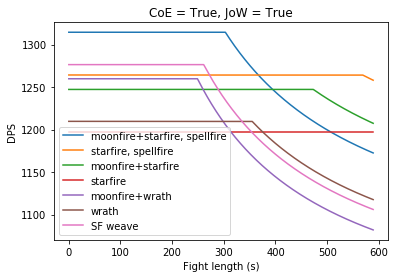

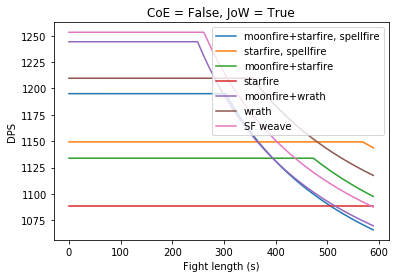

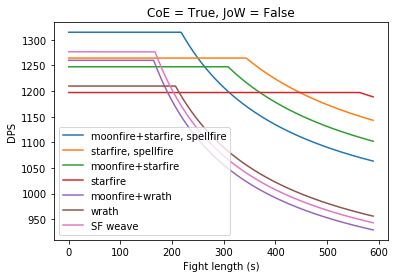

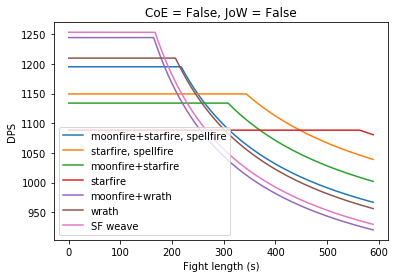

In [52]:
## Comparing wrath and starfire rotation in respective BiS ##

for JoW in [True,False]:
    # Examing both the case of having and not having curse of elements
    for elements in [True,False]:
        # https://seventyupgrades.com/set/dfNkfvvAM87CBLvJfmuATC
        stats_arcane = {
            'base mana':2090,
            'hit':114,
            'crit':206,
            'int':368,
            'spi':194,
            'Mp5':11,
            'haste':0,
            'arcane':1109+36+80+23,
            'nature':887+36+80+23
        }
        arcane_settings = settings() # initialize
        arcane_settings[3] = stats_arcane # updating stats with the above
        arcane_settings[1]['spellfire'] = True # changing setting from default
        arcane_settings[1]['SF idol'] = True # starfire rotation
        arcane_settings[1]['elements'] = elements
        arcane_settings[1]['JoW'] = JoW

        # https://seventyupgrades.com/set/wHj3URGBDfDBcy4tLaoz44
        stats_nature = {
            'base mana':2090,
            'hit':114,
            'crit':201,
            'int':411,
            'spi':247,
            'Mp5':19,
            'haste':0,
            'arcane':1014+36+80+23,
            'nature':1014+36+80+23
        }
        nature_settings = settings() # initialize
        nature_settings[3] = stats_nature # updating stats with the above
        nature_settings[1]['W idol'] = True # wrath rotation
        nature_settings[1]['elements'] = elements
        nature_settings[1]['JoW'] = JoW

        arcane_settings2 = settings() # initialize
        arcane_settings2[3] = stats_nature # using the general set rather than spellfire
        arcane_settings2[1]['SF idol'] = True # still starfire idol
        arcane_settings2[1]['elements'] = elements
        arcane_settings2[1]['JoW'] = JoW
        
        nature_settings2 = settings()
        nature_settings2[3] = stats_nature
        nature_settings2[1]['W idol'] = True
        nature_settings2[1]['elements'] = elements
        nature_settings2[1]['JoW'] = JoW
        nature_settings2[0]['SF weave'] = True

        mfsfDPS,sfDPS,mfsf2DPS,sf2DPS,mfwDPS,wDPS,mfw2DPS = [],[],[],[],[],[],[]
        # iterate over fight lengths
        for T in range(10,600):
            mfsfDPS.append(encounter(T,arcane_settings,burn_rot=['MF','SF'],burn_ranks=[12,8],regen_rot=['SF'],regen_ranks=[1]))
            sfDPS.append(encounter(T,arcane_settings,burn_rot=['SF'],burn_ranks=[8],regen_rot=['SF'],regen_ranks=[1]))
            mfsf2DPS.append(encounter(T,arcane_settings2,burn_rot=['MF','SF'],burn_ranks=[12,8],regen_rot=['SF'],regen_ranks=[1]))
            sf2DPS.append(encounter(T,arcane_settings2,burn_rot=['SF'],burn_ranks=[8],regen_rot=['SF'],regen_ranks=[1]))
            mfwDPS.append(encounter(T,nature_settings,burn_rot=['MF','W'],burn_ranks=[-1,-1,],regen_rot=['W'],regen_ranks=[4]))
            wDPS.append(encounter(T,nature_settings,burn_rot=['W'],burn_ranks=[-1],regen_rot=['W'],regen_ranks=[4]))
            mfw2DPS.append(encounter(T,nature_settings2,burn_rot=['MF','W'],burn_ranks=[-1,-1,],regen_rot=['W'],regen_ranks=[4]))
        plt.plot(mfsfDPS,label='moonfire+starfire, spellfire')
        plt.plot(sfDPS,label='starfire, spellfire')
        plt.plot(mfsf2DPS,label='moonfire+starfire')
        plt.plot(sf2DPS,label='starfire')
        plt.plot(mfwDPS,label='moonfire+wrath')
        plt.plot(wDPS,label='wrath')
        plt.plot(mfw2DPS,label='SF weave')
        plt.title('CoE = '+str(elements)+', JoW = '+str(JoW))
        plt.ylabel('DPS')
        plt.xlabel('Fight length (s)')
        plt.legend()
        plt.show()

In [6]:
def get_stat_weights(rotation,fight_data=(10,600)):
    """Vary every stat by 1 and compare the dps increase to that of spellpower"""
    burn_rot,burn_ranks,regen_rot,regen_ranks = rotation
    min_length,max_length = fight_data
    DPS_weights = np.zeros((9,max_length-min_length+1))
    SP_weights = np.zeros((8,max_length-min_length+1))
    for T in range(min_length,max_length+1):
        variations = [0,0,0,0,0,0,0,0,0]
        default=encounter(T,settings(variations),burn_rot,burn_ranks,regen_rot,regen_ranks)
        for v in range(0,9):
            variations[v]=1
            dps_change = encounter(T,settings(variations),burn_rot,burn_ranks,regen_rot,regen_ranks)-default
            DPS_weights[v,T-min_length] = dps_change
            if v==0:
                normalizer = dps_change
            else:
                SP_weights[v-1,T-min_length]=dps_change/normalizer
            variations[v]=0
    return SP_weights,DPS_weights

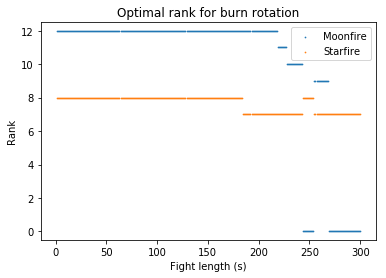

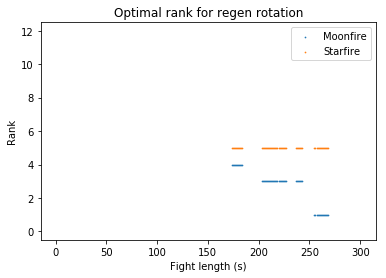

In [134]:
## Finding the optimal ranks to use based on fight length ##

# https://seventyupgrades.com/set/dfNkfvvAM87CBLvJfmuATC
stat_arc = {
    'base mana':2090,
    'hit':114,
    'crit':206,
    'int':368,
    'spi':194,
    'Mp5':11,
    'haste':0,
    'arcane':1109+36+80+23,
    'nature':887+36+80+23
}
arc_settings = settings()
arc_settings[1]['spellfire'] = True
arc_settings[1]['SF idol'] = True

data = np.zeros((300,13,8,13,8))
for MFrank in range(0,13):
    for SFrank in range(1,9):
        for MFrank2 in range(0,MFrank+1):
            for SFrank2 in range(1,SFrank+1):
                for T in range(1,301):
                    if MFrank!=0:
                        rot1 = ['MF','SF']; ranks1 = [MFrank,SFrank]
                    else:
                        rot1 = ['SF']; ranks1 = [SFrank]
                    if MFrank2!=0:
                        rot2 = ['MF','SF']; ranks2 = [MFrank2,SFrank2]
                    else:
                        rot2 = ['SF']; ranks2 = [SFrank]
                    data[T-1,MFrank,SFrank-1,MFrank2,SFrank2-1] = encounter(T,arc_settings,rot1,ranks1,rot2,ranks2)
initial_max = np.amax(data[1])
optimal_ranks = np.zeros((300,4))
Ts=np.linspace(1,300,300)
for T in Ts:
    T = int(T)
    maximum = np.amax(data[T-1])
    where = np.where(data[T-1]==maximum)
    mf1 = where[0][0]
    sf1 = where[1][0]+1
    if len(where[0])!=1:
        mf2 = -10
        sf2 = -10
    else:
        mf2 = where[2][0]
        sf2 = where[3][0]+1
    optimal_ranks[T-1,:] = [mf1,sf1,mf2,sf2]
plt.scatter(Ts,optimal_ranks[:,0],s=0.5,label='Moonfire')
plt.scatter(Ts,optimal_ranks[:,1],s=0.5,label='Starfire')
plt.ylabel('Rank')
plt.xlabel('Fight length (s)')
plt.ylim(-0.5,12.5)
plt.title('Optimal rank for burn rotation')
plt.legend()
plt.show()
plt.scatter(Ts,optimal_ranks[:,2],s=0.5,label='Moonfire')
plt.scatter(Ts,optimal_ranks[:,3],s=0.5,label='Starfire')
plt.ylabel('Rank')
plt.xlabel('Fight length (s)')
plt.ylim(-0.5,12.5)
plt.title('Optimal rank for regen rotation')
plt.legend()
plt.show()

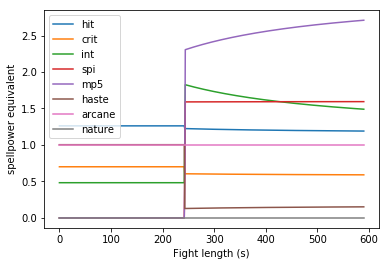

In [135]:
# plotting the stat weights
names = ['hit','crit','int','spi','mp5','haste','arcane','nature']
for n,stat in enumerate(get_stat_weights([['SF'],[-1],['SF'],[1]])[0]):
    plt.plot(stat,label=names[n])
plt.ylabel('spellpower equivalent')
plt.xlabel('Fight length (s)')
plt.legend()
plt.show()